In [2]:
script=False
DATAPATH='~/DataLocal/algo_fin_new/five_min_data/'

Need to import algorithms from stable-baselines3

In [3]:
from stable_baselines3 import PPO,A2C,DQN
from stable_baselines3.common.vec_env import StackedObservations
from stable_baselines3.common.monitor import Monitor as Mon

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
import import_ipynb
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from datetime import datetime as dt
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import pickle
from threading import Thread
import threading
from IPython import display
import time,getopt,sys,os

In [6]:
from feeds import BackFeed,DataFeed
from featfuncs import feat_aug,add_addl_features_feed,add_ta_features_feed,add_sym_feature_feed
from featfuncs import add_global_indices_feed

importing Jupyter notebook from feeds.ipynb
importing Jupyter notebook from synfeed.ipynb
importing Jupyter notebook from india_calendar.ipynb
importing Jupyter notebook from featfuncs.ipynb


In [7]:
from feed_env import Episode
import aspectlib

importing Jupyter notebook from feed_env.ipynb


### Trading strategies as agents

RL(++)StratAgents imported from ruleagents<br>

In [8]:
from rlagents import RLStratAgentDyn

importing Jupyter notebook from rlagents.ipynb
importing Jupyter notebook from aiagentbase.ipynb


### Strategy Testing for RLStratAgent using BackTest

In [9]:
from backtest import Backtest
from feeds import BackFeed,DataFeed
from validation import Validate

importing Jupyter notebook from backtest.ipynb
importing Jupyter notebook from validation.ipynb


<b>Configuration for training RL model<b>

In [10]:
algorithm=PPO
synthetic=False #use synthetic data
nd,nw=4,5 #for BackFeed

In [11]:
if script:
    try:
        opts,args = getopt.getopt(sys.argv[1:],"hl:f:d:m:s:w:t:p:",["load=","feed=","datafile=","modelname=","synthetic","weeks","deploy"])
    except getopt.GetoptError:
        print('rlagents_train.py -l <load:True/False> -f <scan:back/data> -d <datafile> -m <modelname> -s <synthetic> -w <weeks> -p <deploy>')
        sys.exit(2)
    load,feed,date,modelname=False,'back','01-Jan-2000','RLA1.pth'
    deploy=True
    date=datetime.today().strftime('%d-%b-%Y')
    for opt, arg in opts:
        if opt == "-h":
            print('rlagents_train.py -l <load:True/False> -f <scan:back/data> -d <datafile> -m <modelname> -s <synthetic> -w <weeks> -p <deploy>')
            sys.exit()
        elif opt in ("-l", "--load"):
            load = (lambda x: True if x=='True' else False)(arg)
        elif opt in ("-f", "--feed"):
            feed = (lambda x: 'data' if x=='data' else 'back')(arg)
        elif opt in ("-d", "--datafile"):
            datafile = arg.split('/')[-1]
        elif opt in ("-m", "--modelname"):
            modelname = arg
        elif opt in ("-s", "--synthetic"):
            synthetic = (lambda x: True if x=='True' else False)(arg)
        elif opt in ("-w", "--weeks"):
            nw = int(arg)
        elif opt in ("-p", "--deploy"):
            deploy = (lambda x: True if x=='True' else False)(arg)
    if len(opts)==0: 
        print('rlagents_train.py -l <load:True/False> -f <scan:back/data> -d <datafile> -m <modelname> -s <synthetic> -w <weeks> -p <deploy>')
        sys.exit()
    print(f"load:{load},feed:{feed},datafile:{datafile},modelname:{modelname},synthetic:{synthetic},weeks:{nw},deploy:{deploy}")
    loadfeed=load
    if feed=='data': datafeed=True
    else: datafeed=False

In [12]:
if not script:
    loadfeed=False
    datafeed=False
    datafile='augdata_16-Dec-2022_5m.csv'
    modelname='RLA1.pth' # replace with modelname if model to be saved to saved_models
    date=datetime.today().strftime('%d-%b-%Y')
    deploy=True

In [13]:
n_steps=2048 # reduce for debugging only else 2048

In [14]:
def stringify(x):
    return pd.to_datetime(x['Datetime']).strftime('%d-%b-%Y')

In [15]:
import pickle
if not loadfeed and not datafeed:
    data=pd.read_csv('./capvol100.csv')
    tickers=list(data.iloc[0:10]['ticker'].values)
    print('Creating feed')
    feed=BackFeed(tickers=tickers,nd=nd,nw=nw,interval='5m',synthetic=synthetic)
    print('Processing feed')
    add_addl_features_feed(feed,tickers=feed.tickers)
    add_sym_feature_feed(feed,tickers=feed.tickers)
    add_global_indices_feed(feed)
    with open('../../temp_data/btfeed10.pickle','wb') as f: pickle.dump(feed,f)
elif loadfeed and not datafeed:
    with open('../../temp_data/btfeed10.pickle','rb') as f: feed=pickle.load(f)

Creating feed
Processing feed


In [16]:
if not loadfeed and datafeed:
    #DATAFILE=DATAPATH+'augdata_'+date+'_5m.csv'
    DATAFILE=DATAPATH+datafile
    print('Reading datafile')
    df=pd.read_csv(DATAFILE)
    if 'Date' not in df.columns: 
        print('Adding Date')
        df['Date']=df.apply(stringify,axis=1)
    print('Creating feed')
    feed=DataFeed(tickers=list(df.ticker.unique()[0:10]),dfgiven=True,df=df)
    print('Processing feed')
    add_addl_features_feed(feed,tickers=feed.tickers)
    add_sym_feature_feed(feed,tickers=feed.tickers)
    add_global_indices_feed(feed)
    with open('../../temp_data/btdatafeed.pickle','wb') as f: pickle.dump(feed,f)
elif loadfeed and datafeed:
    with open('../../temp_data/btdatafeed.pickle','rb') as f: feed=pickle.load(f)

In [17]:
agent=RLStratAgentDyn(algorithm,monclass=Mon,soclass=StackedObservations,n_steps=n_steps,verbose=1,win=5,
                   metarl=True)
agent.use_memory=True #depends on whether RL algorithm uses memory for state computation
agent.debug=False

Using cpu device
Wrapping the env in a DummyVecEnv.


In [18]:
agent.training=False

In [19]:
if modelname and os.path.exists('./saved_models/'+modelname): 
    agent.load_model(filepath='./saved_models/'+modelname)

In [21]:
@aspectlib.Aspect
def my_decorator(*args, **kwargs):
    # print("Got called with args: %s kwargs: %s" % (args, kwargs))
    # result = yield
    # print(" ... and the result is: %s" % (result,))
    state,rew,done,exit_type = yield
    # args[0].policy.logL+=[(state.keys(),rew,done,exit_type)]
    args[0].policy.reward((rew,done,{'exit_type':exit_type}))
    return state,rew,done,exit_type

In [22]:
aspectlib.weave(Episode, my_decorator, methods='env_step')

In [25]:
bt=Backtest(feed,tickers=feed.tickers,add_features=False,target=5,stop=5,txcost=0.001,
            loc_exit=True,scan=False,topk=5,deploy=deploy,save_dfs=False,
            save_func=None)

In [26]:
bt.run_all(tickers=feed.tickers,model=agent,verbose=False)

## Trading Plots

In [27]:
import plotly.graph_objects as go

In [28]:
import plotly.express as px

In [29]:
def annotate_action(rew,act,df):
    if rew[1]>=0:color='Green'
    else: color='Red'
    if act[0]==1:text='Buy'
    elif act[0]==-1:text='Sell'
    ann=dict(font=dict(color=color,size=15),x=df.index[rew[0]],y=df.iloc[rew[0]]['Close'],
             showarrow=True,text=text)
    return ann

In [30]:
def annotate_exit(rew,act,anns,df):
    if rew[1]>=0:color='Green'
    else: color='Red'
    X=[a['x'] for a in anns if a is not None]
    if df.index[rew[2]] in X: 
        idx=X.index(df.index[rew[2]])
        anns[idx]['text']='Ex&'+anns[idx]['text']
    else:
        anns+=[dict(font=dict(color=color,size=15),x=df.index[rew[2]],y=df.iloc[rew[2]]['Close'],
                    showarrow=True,text='Exit')]

In [46]:
def plot_ticker_date(bt,ticker,date):
    global fig
    df=feed.ndata[ticker][date]
    df=df.loc[df['Date']==date]
    fig = go.Figure(data=
        [go.Candlestick(x = df.index,
                        open  = df["Open"],
                        high  = df["High"],
                        low   = df["Low"],
                        close = df["Close"])]
    )
    fig.update_layout(
        title=f'{ticker} on {date}',
        yaxis_title="Price"
    )
    anns=[]
    for r,a in zip(bt.results[ticker][date]['rew'],bt.results[ticker][date]['acts']):
        anns+=[annotate_action(r,a,df)]
    for r,a in zip(bt.results[ticker][date]['rew'],bt.results[ticker][date]['acts']):
        anns+=[annotate_exit(r,a,anns,df)]
    for a in anns: 
        if a is not None: fig.add_annotation(a)
    fig.show()
    return fig

In [47]:
def combine_plotly_figs_to_html(plotly_figs, html_fname, include_plotlyjs='cdn', 
                                separator=None, auto_open=False):
    with open(html_fname, 'w') as f:
        f.write(plotly_figs[0].to_html(include_plotlyjs=include_plotlyjs))
        for fig in plotly_figs[1:]:
            if separator:
                f.write(separator)
            f.write(fig.to_html(full_html=False, include_plotlyjs=False))

    if auto_open:
        import pathlib, webbrowser
        uri = pathlib.Path(html_fname).absolute().as_uri()
        webbrowser.open(uri)

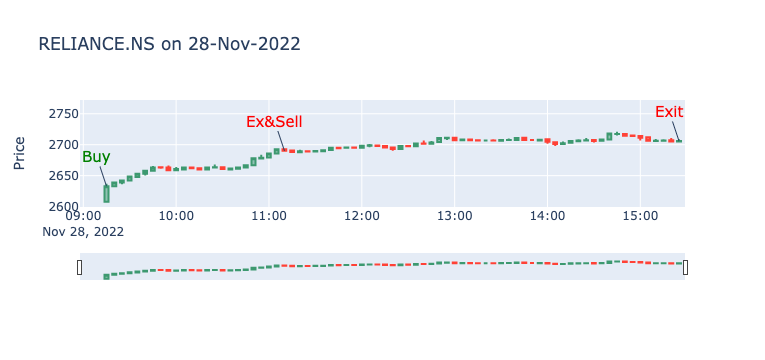

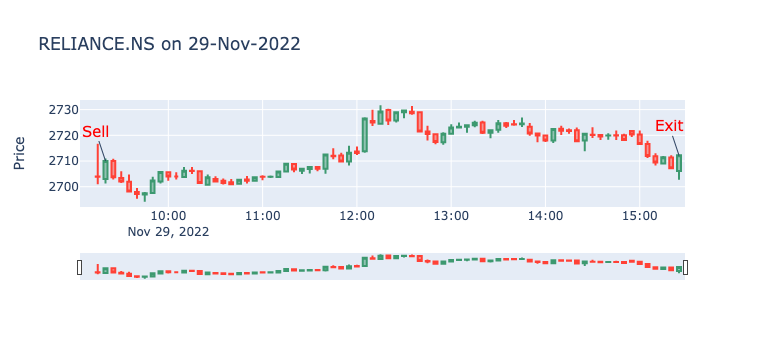

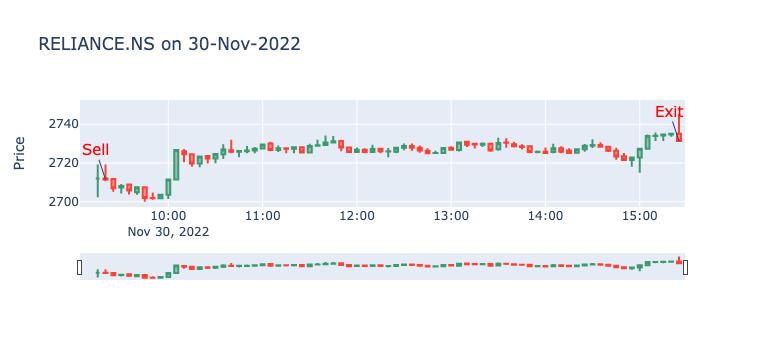

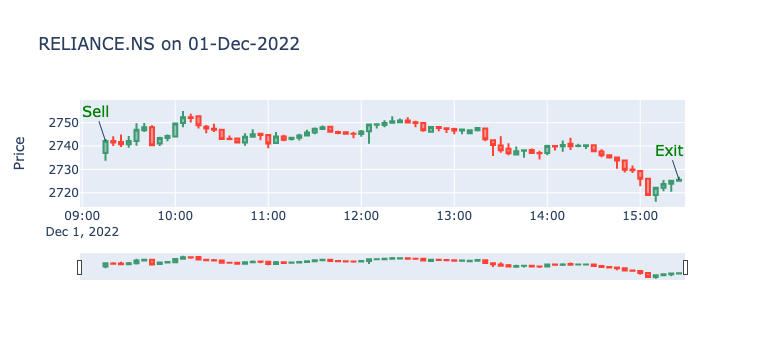

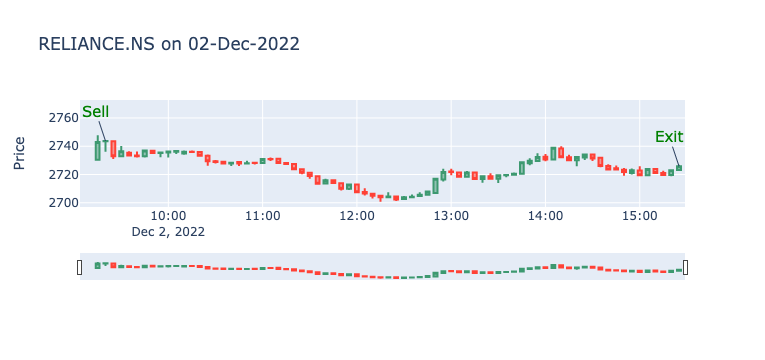

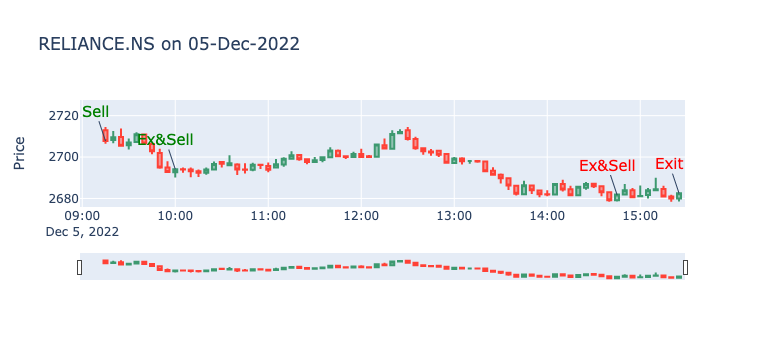

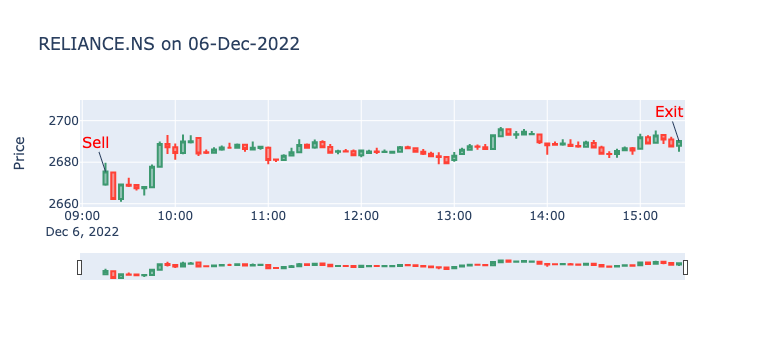

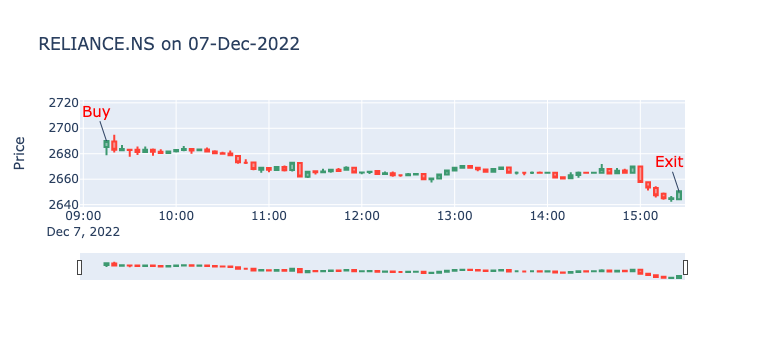

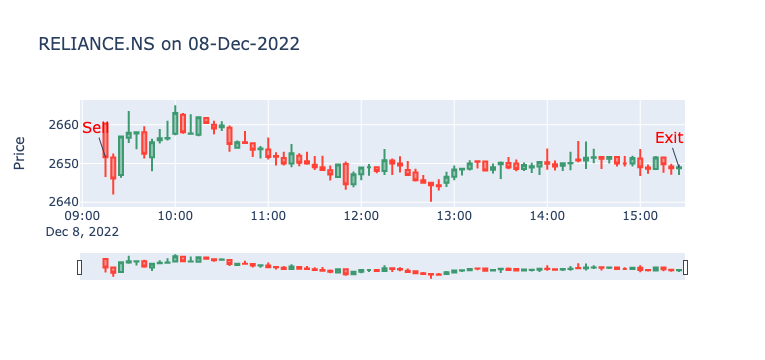

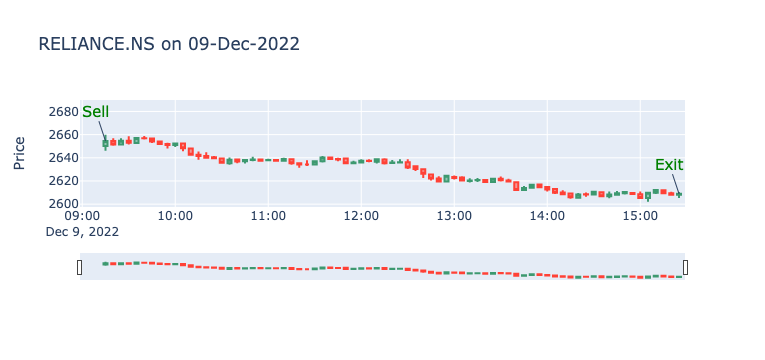

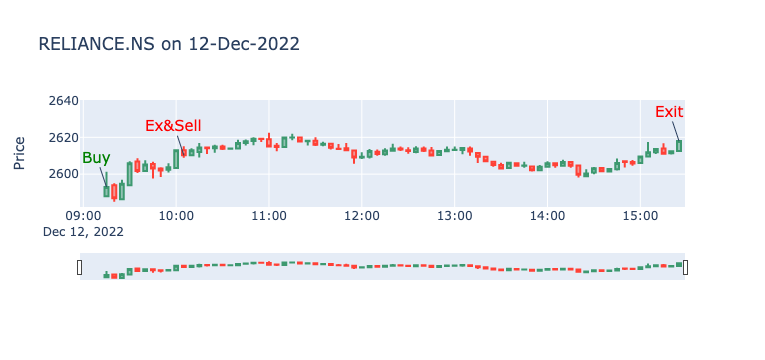

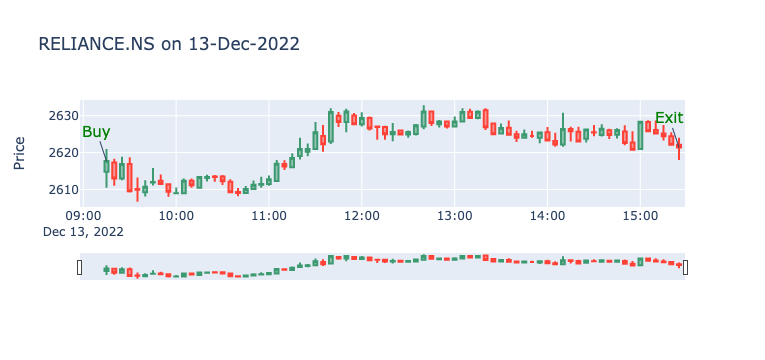

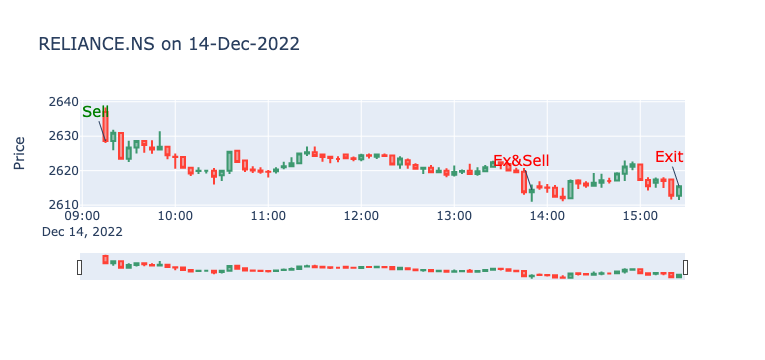

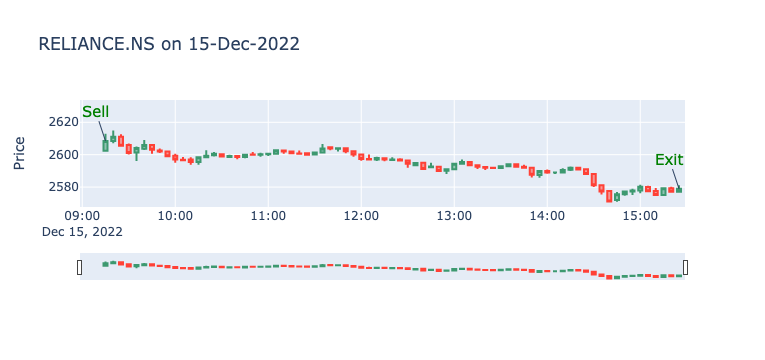

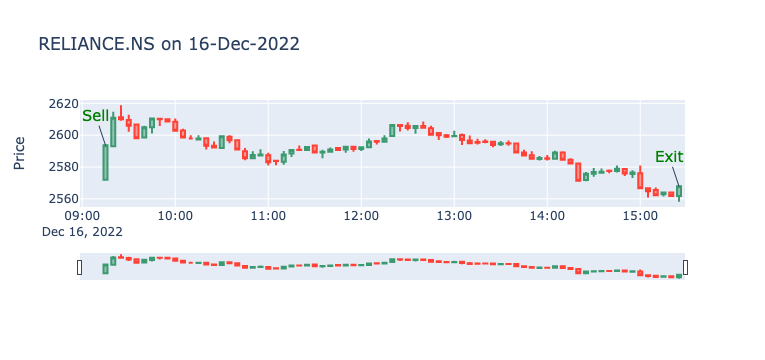

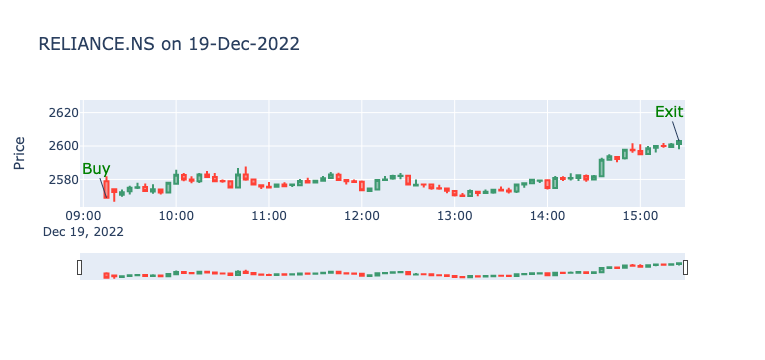

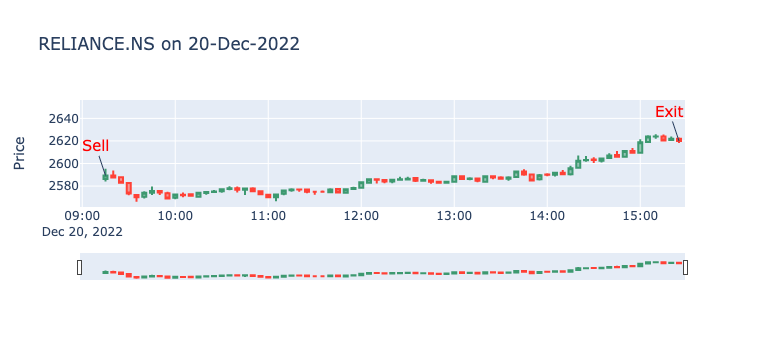

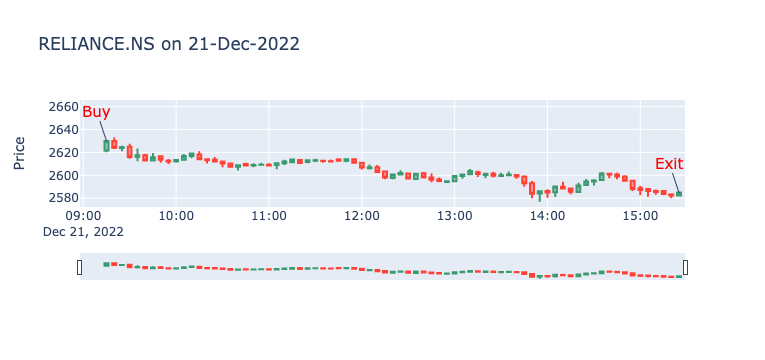

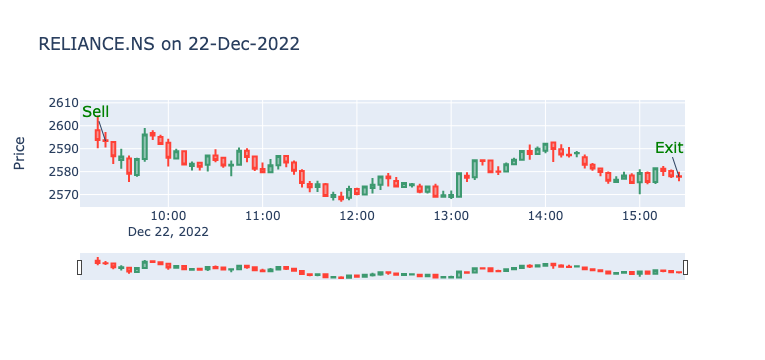

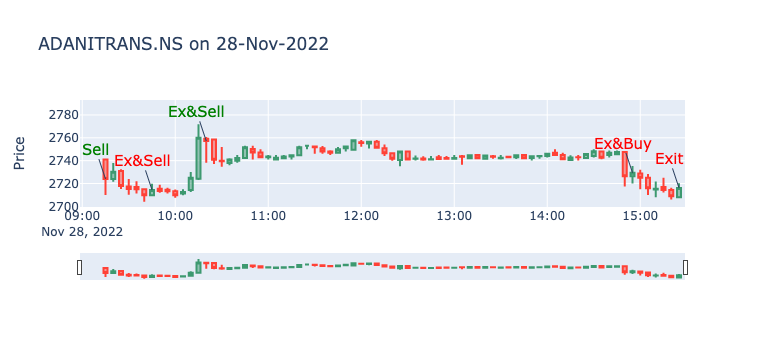

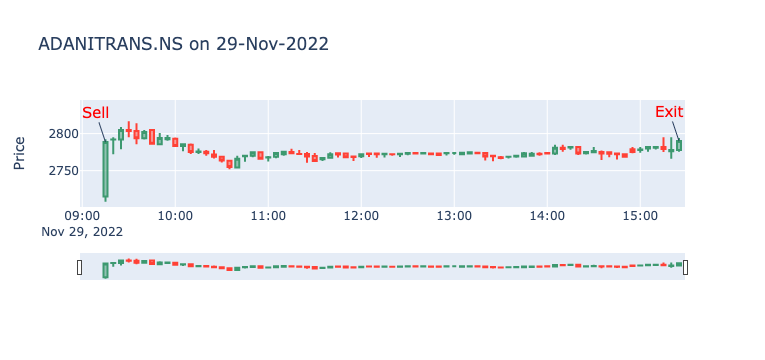

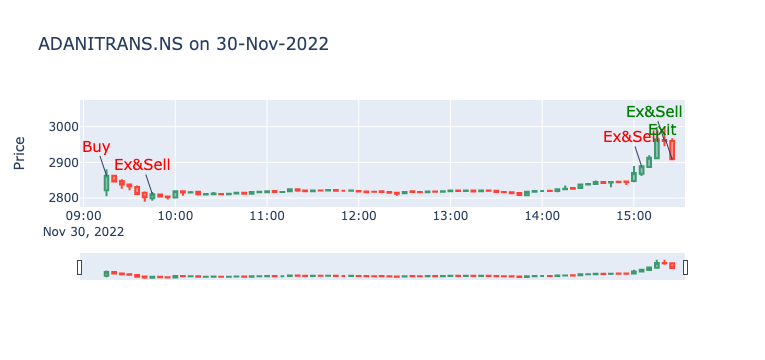

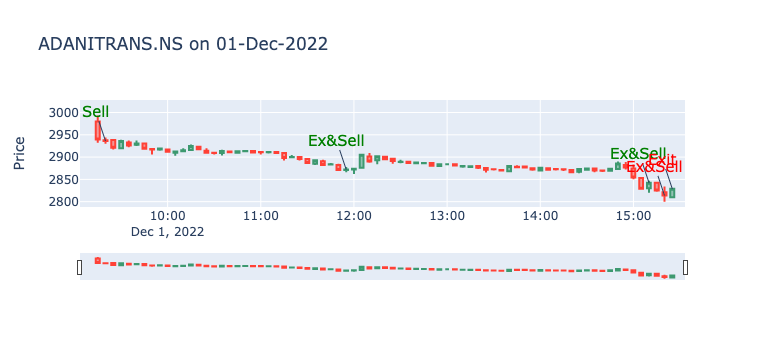

In [48]:
figs=[]
for t in bt.results:
    for d in bt.results[t]:
        figs+=[plot_ticker_date(bt,t,d)]

In [50]:
combine_plotly_figs_to_html(figs,'/tmp/charts.html',auto_open=True)